# All About Inference - Vision

First let's install the library:

In [331]:
!pip install wwf >> /dev/null

In [332]:
from wwf.utils import state_versions

In [334]:
state_versions('fastai,fastcore,wwf,torch,torchvision,onnxruntime'.split(','))


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `wwf`, `torch`, `torchvision`, and `onnxruntime` currently running at the time of writing this:
* `fastai` : 2.3.1 
* `fastcore` : 1.3.20 
* `wwf` : 0.0.14 
* `torch` : 1.8.1+cu101 
* `torchvision` : 0.9.1+cu101 
* `onnxruntime` : 1.7.0 
---

## Raw fastai

- Transforms: Keep it simple, just Resize and basic augmentation

We'll use the pets dataset quickly (accuracy doesn't 100% matter here, we just want repeatable model results):

In [1]:
from fastai.vision.all import *

In [3]:
def label_func(o): return o[0].isupper()

In [4]:
set_seed(99, True)
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2,
    label_func=label_func, item_tfms=Resize(224))

Let's look closely at exactly what those transforms are:

In [5]:
dls.after_item

Pipeline: Resize -- {'size': (224, 224), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [6]:
dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

General rule of thumb, the `Resize` transform specifically will center crop on the validation set. 

Let's briefly train and grab a prediction quickly:

In [87]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [8]:
learn.dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

In [90]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.167857,0.038699,0.985792,00:43


epoch,train_loss,valid_loss,accuracy,time
0,0.056371,0.029493,0.989175,00:44


In [5]:
fname = get_image_files(path)[0]; fname

Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg')

In [11]:
%%time
learn.predict(fname)

CPU times: user 48 ms, sys: 3.34 ms, total: 51.4 ms
Wall time: 60.4 ms


('False', tensor(0), tensor([1.0000e+00, 1.1277e-06]))

In [12]:
%%time
dl = learn.dls.test_dl([fname])
p = learn.get_preds(dl=dl)

CPU times: user 43.2 ms, sys: 44.2 ms, total: 87.3 ms
Wall time: 167 ms


In [13]:
p

(tensor([[1.0000e+00, 1.1277e-06]]), None)

Alright so this is our baseline. Let's try and recreate it from here.

## Raw torch model w/ fastai preprocess

From here on out, we're not using fastai to generate a model, this means doing everything ourself and recreating what fastai does. First let's save our model's weights:

In [14]:
torch.save(learn.model.state_dict(), 'model.pt')

And now we need to fully recreate our model. Let's look at the `head` (what fastai writes custom):

In [15]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

So we can see we'll need fastai's `Flatten` and `AdaptiveConcatPool2d` layers, and we'll need a way to cut our model to the body. Let's grab those:

In [20]:
@module(full=False)
def Flatten(self, x):
    "Flatten `x` to a single dimension, e.g. at end of a model. `full` for rank-1 tensor"
    return TensorBase(x.view(-1) if self.full else x.view(x.size(0), -1))

In [21]:
class FlattenLayer(nn.Module):
    "Recreating fastai's `Flatten` layer"
    def __init__(self, full=False): 
        super().__init__()
        self.full = full
    def forward(self, x): return x.view(x.size(0), -1)

In [22]:
class ConcatPool(nn.Module):
    "Recreating AdaptiveConcatPool2d"
    def __init__(self, size=None):
        super().__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x):
        # Return the cat of mp and ap
        return torch.cat([self.mp(x), self.ap(x)], 1)

Next let's make our head:

In [23]:
head = nn.Sequential(
    ConcatPool(size=1),
    FlattenLayer(full=False),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.25),
    nn.Linear(1024, 512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 2, bias=False) # last dim is number of classes
)

And next our body, let's look at how `create_body` does it:

In [24]:
create_body??

Let's try making it ourselves now:

The cut for a resnet is [-2](https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L113)

In [25]:
import torchvision

In [26]:
body = torchvision.models.resnet18(pretrained=True)

In [27]:
body = nn.Sequential(*list(body.children())[:-2])

And now we can wrap it in a `nn.Sequential`:

In [28]:
net = nn.Sequential(body, head)

And load in our weights:

In [29]:
dic = torch.load('model.pt')

In [30]:
net.load_state_dict(dic)

<All keys matched successfully>

Next let's try to get a prediction. First we'll mock inference by exporting the `DataLoaders` specifically:

In [31]:
torch.save(dls.new_empty(), 'dls.pkl')

And now load them back in:

In [28]:
del dls
dls = torch.load('dls.pkl')

We'll build a `test_dl` from our file:

In [29]:
dl = dls.test_dl([fname])

And get a prediction:

In [30]:
x_fastai, = next(iter(dl))

In [31]:
x_fastai.shape

torch.Size([1, 3, 224, 224])

In [32]:
with torch.no_grad():
    net.eval()
    net.cuda()
    pred = net(x_fastai)

Alright, how does it compare?

In [33]:
pred

tensor([[ 5.2269, -8.4685]], device='cuda:0')

That doesn't look right! And it's because fastai does a `softmax` and an `argmax` (what we saw earlier). Let's do that now:

In [34]:
pred.softmax(dim=1)

tensor([[1.0000e+00, 1.1277e-06]], device='cuda:0')

In [35]:
pred.argmax(dim=1)

tensor([0], device='cuda:0')

And for our vocab:

In [35]:
vocab = [False, True]
vocab[pred.argmax(dim=1)]

False

What we had earlier:

`('False', tensor(0), tensor([1.0000e+00, 9.6838e-08]))`

As we can see, it's the same. Now that we have a working benchmark, let's start removing the fastai:

## Raw torch model w/ pytorch and PIL preprocess

In [10]:
from fastai.vision.augment import _get_sz

In [11]:
pad_modes = {'zeros': 'constant', 'border': 'edge', 'reflection': 'reflect'}

In [12]:
im = PILImage.create(fname)
size = (224,224)
mode = Image.BILINEAR
method = ResizeMethod.Crop

# Resize Before Call
pcts = (0.5,0.5)

# Resize Encodes
orig_sz = _get_sz(im)
w,h = orig_sz
op = (operator.lt, operator.gt)[method==ResizeMethod.Pad]
m = w/size[0] if op(w/size[0], h/size[1]) else h/size[1]
cp_sz = (int(m*size[0]), int(m*size[1]))
tl = fastuple(int(pcts[0] * (w-cp_sz[0])), int(pcts[1]*(h-cp_sz[1])))

# crop_pad
sz, tl = fastuple(cp_sz), fastuple(tl)

# do_crop_pad
if any(tl.ge(0)):
    # At least one dim inside im, needs to be cropped
    c = tl.max(0)
    im = im.crop((*c, *c.add(sz).min(orig_sz)))
if any(tl.lt(0)):
    # At least one dim outside im, needs to be padded
    p = (-tl).max(0)
    f = (sz-orig_sz-p).max(0)
    im = pad(im, (*p, *f), padding_mode=pad_modes['reflection'])

im = im.resize((224,224), Image.BILINEAR)

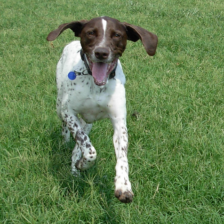

In [13]:
im

Let's rewrite that as a usable function:

In [14]:
from fastcore.basics import fastuple
from torchvision.transforms.functional import pad

def center_crop(
    x:Image.Image, 
    width:int, 
    height:int,
    method:str='crop',
    resample_mode:int=Image.BILINEAR,
    pad_mode:str='reflection'
) -> Image.Image:
    """
    Mimics fastai center cropping

    Inputs:
        x: An Image to crop
        w: A width
        h: A height
        method: A resize method: "crop", "pad", or "squish"
        resample_mode: An `Image` resample mode, such as `Image.BILINEAR` or `Image.NEAREST`
        pad_mode: A padding mode to use, either `border`, `reflection`, or `zeros`

    Outputs:
        A cropped Image.Image
    """
    _methods = ['crop', 'pad', 'squish']
    if method not in _methods: raise TypeError(f'Resize method {method} is not a valid method.\nMust be one of {_methods}')
    
    _modes = {'border': 'edge', 'reflection': 'reflect', 'zeros': 'constant'}
    if pad_mode in _modes.keys():
        pad_mode = _modes[pad_mode]
    else:
        raise TypeError(f'Pad mode {pad_mode} is not a valid mode.\nMust be one of the following:\n{_modes.values()}')

    # Get center percentages if we don't squish
    if method != 'squish': pcts = (0.5, 0.5)

    # Perform Resize's `encodes`
    orig_sz = x.size
    if method == 'squish':
        sz, tl = fastuple(orig_sz), fastuple(0,0)
    else:
        orig_w,orig_h = orig_sz
        op = (operator.lt, operator.gt)[method=='pad']
        m = orig_w/width if op(orig_w/width, orig_h/height) else orig_h/height
        cp_sz = (int(m*width), int(m*height))
        tl = fastuple(int(.5 * (orig_w-cp_sz[0])), int(.5 * (orig_h-cp_sz[1])))
        sz, tl = fastuple(cp_sz), fastuple(tl)
    
    # Perform _do_crop_pad
    if any(tl.ge(0)):
        # At least one dim in x, needs to be cropped\
        c = tl.max(0)
        x = x.crop((*c, *c.add(sz).min(orig_sz)))
    if any(tl.lt(0)):
        # At least one dim outside im, needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz-p).max(0)
        x = pad(x, (*p, *f), padding_mode=pad_mode)
    return x.resize((width,height), resample_mode)

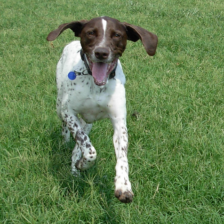

In [15]:
im = Image.open(fname)
center_crop(im, 224, 224)

That looks better! What else do we need to do?

The last two transforms are converting this image to a `tensor` and `Normalizing` it based on our `imagenet_stats`. Let's recreate that:

In [16]:
import torchvision.transforms as T

In [17]:
tfms = T.Compose([
                  T.ToTensor(),
                  T.Normalize([0.485, 0.456, 0.406],
                              [0.229, 0.224, 0.225])
])

And now let's try performing inference!

In [18]:
im = Image.open(fname)
im = center_crop(im, 224, 224)
x = tfms(im).unsqueeze(0) # Batchify it

In [32]:
with torch.no_grad():
    net.eval()
    net.cuda()
    pred = net(x.cuda())

In [36]:
pred.softmax(dim=1), pred.argmax(dim=1), vocab[pred.argmax(dim=1)]

(tensor([[1.0000e+00, 1.1277e-06]], device='cuda:0'),
 tensor([0], device='cuda:0'),
 False)

In [37]:
pil_im = im

And it's exactly the same!

## cv2 and torch

> Note: We cannot 100% recreate our original image here, as how cv2 handles images is different than Pillow. You will see an accuracy drop

Let's try recreating what we did in `PIL` in `cv2` now.

In [38]:
import cv2

In [39]:
im = cv2.imread(str(fname), 1)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [40]:
from google.colab.patches import cv2_imshow

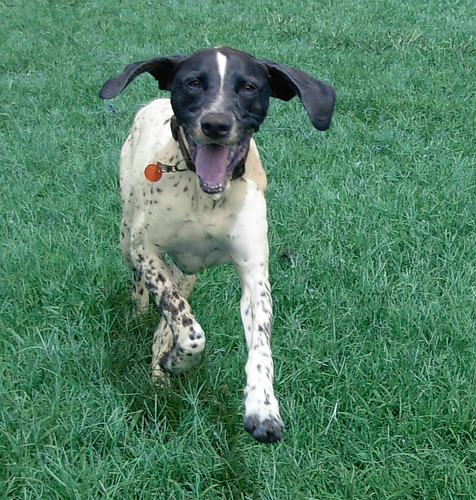

In [41]:
cv2_imshow(im)

In [42]:
method = 'crop'
mode = 'reflect'
pcts = (0.5, 0.5)

In [43]:
orig_sz = im.shape[:2]
orig_w, orig_h = orig_sz

In [44]:
width, height = 224, 224

In [45]:
op = (operator.lt, operator.gt)[method=='pad']
m = orig_w/width if op(orig_w/width, orig_h/height) else orig_h/height

In [46]:
cp_sz = (int(m*width), int(m*height))
tl = fastuple(int(.5 * (orig_w-cp_sz[0])), int(.5 * (orig_h-cp_sz[1])))
sz, tl = fastuple(cp_sz), fastuple(tl)

In [47]:
c = tl.max(0)

In [48]:
tl

(12, 0)

In [49]:
c.add(sz).min(orig_sz)

(488, 476)

In [50]:
o = c.add(sz).min(orig_sz)

In [51]:
c_im = cv2.resize(im[tl[1]:o[1], tl[0]:o[0]], (224,224), interpolation = cv2.INTER_AREA)

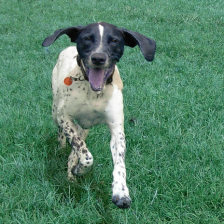

In [52]:
cv2_imshow(c_im)

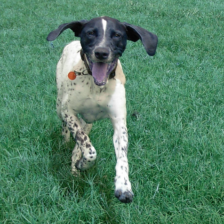

In [53]:
cv2_imshow(np.array(pil_im))

In [54]:
(c_im - np.array(pil_im)).sum()

18028450

In [55]:
def plt_display(image, title):
    """
    Plot an image with title
    Source: https://towardsdatascience.com/image-read-and-resize-with-opencv-tensorflow-and-pil-3e0f29b992be
    """
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

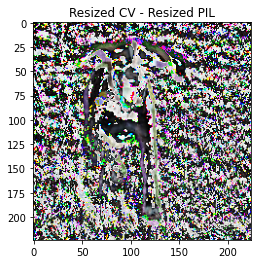

In [56]:
plt_display(np.abs(c_im - np.array(pil_im)), 'Resized CV - Resized PIL')

We can see they're quite different, but as we stated earlier a difference is expected. This is due to:

> PIL library doesn’t provide any support for half-pixel correction, and so there is no by default support for this. Since we know TF and OpenCV are consistent, we can expect the same results when considering the difference between PIL and TF as well.
Hence, when using PIL framework, one must keep this in mind that one cannot switch directly to another framework if the work is dependent on the pre-processing of the images such as above. This will lead to unexpected results.

Now let's write that into a function, and mimic what we did earlier:

In [57]:
from fastcore.basics import fastuple
from torchvision.transforms.functional import pad

def center_crop_CV(
    x:Image.Image, 
    width:int, 
    height:int,
    method:str='crop',
    resample_mode:int=cv2.INTER_AREA,
    pad_mode:str='reflection'
) -> Image.Image:
    """
    Mimics fastai center cropping

    Inputs:
        x: An Image to crop
        w: A width
        h: A height
        method: A resize method: "crop", "pad", or "squish"
        resample_mode: An `Image` resample mode, such as `cv2.INTER_AREA` or `cv2.INTER_NEAREST`
        pad_mode: A padding mode to use, either `border`, `reflection`, or `zeros`

    Outputs:
        A cropped Image.Image
    """
    _methods = ['crop', 'pad', 'squish']
    if method not in _methods: raise TypeError(f'Resize method {method} is not a valid method.\nMust be one of {_methods}')
    
    _modes = {'border': 'edge', 'reflection': 'reflect', 'zeros': 'constant'}
    if pad_mode in _modes.keys():
        pad_mode = _modes[pad_mode]
    else:
        raise TypeError(f'Pad mode {pad_mode} is not a valid mode.\nMust be one of the following:\n{_modes.values()}')

    # Get center percentages if we don't squish
    if method != 'squish': pcts = (0.5, 0.5)

    # Perform Resize's `encodes`
    orig_sz = im.shape[:2]
    if method == 'squish':
        sz, tl = fastuple(orig_sz), fastuple(0,0)
    else:
        orig_w,orig_h = orig_sz
        op = (operator.lt, operator.gt)[method=='pad']
        m = orig_w/width if op(orig_w/width, orig_h/height) else orig_h/height
        cp_sz = (int(m*width), int(m*height))
        tl = fastuple(int(.5 * (orig_w-cp_sz[0])), int(.5 * (orig_h-cp_sz[1])))
        sz, tl = fastuple(cp_sz), fastuple(tl)
    
    # Perform _do_crop_pad
    if any(tl.ge(0)):
        # At least one dim in x, needs to be cropped
        c = tl.max(0)
        o = c.add(sz).min(orig_sz)
        x = x[c[1]:o[1], c[0]:o[0]]
    if any(tl.lt(0)):
        # At least one dim outside im, needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz-p).max(0)
        x = pad(x, (*p, *f), padding_mode=pad_mode)
    return cv2.resize(x[tl[1]:o[1], tl[0]:o[0]], (width,height), interpolation = cv2.INTER_AREA)

In [58]:
im = cv2.imread(str(fname), 1)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

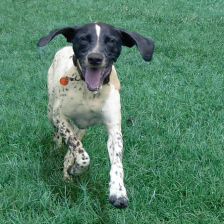

In [59]:
cv2_imshow(center_crop_CV(im, 224,224))

Let's test the performance:

In [60]:
im = cv2.imread(str(fname), 1)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = center_crop_CV(im, 224, 224)
x = tfms(im).unsqueeze(0) # Batchify it

In [61]:
with torch.no_grad():
    net.eval()
    net.cuda()
    pred = net(x.cuda())

In [62]:
pred.softmax(dim=1), pred.argmax(dim=1), vocab[pred.argmax(dim=1)]

(tensor([[1.0000e+00, 1.0316e-06]], device='cuda:0'),
 tensor([0], device='cuda:0'),
 False)

Our original prediction was:

```python
(tensor([[1.0000e+00, 1.1277e-06]], device='cuda:0'),
 tensor([0], device='cuda:0'),
 False)
 ```
 So it's *extremely* close, but not quite

## Pillow + ONNX

ONNX wants everything as numpy arrays, so let's do that for it. We'll rewrite all our transforms to work off just numpy arrays, and copy torchvisions' `pad` 

### Resize

In [63]:
from PIL import ImageOps, Image

In [64]:
def _parse_fill(fill, img, min_pil_version, name="fillcolor"):
    # Process fill color for affine transforms
    import PIL; PILLOW_VERSION = PIL.__version__
    major_found, minor_found = (int(v) for v in PILLOW_VERSION.split('.')[:2])
    major_required, minor_required = (int(v) for v in min_pil_version.split('.')[:2])
    if major_found < major_required or (major_found == major_required and minor_found < minor_required):
        if fill is None:
            return {}
        else:
            msg = ("The option to fill background area of the transformed image, "
                   "requires pillow>={}")
            raise RuntimeError(msg.format(min_pil_version))

    num_bands = len(img.getbands())
    if fill is None:
        fill = 0
    if isinstance(fill, (int, float)) and num_bands > 1:
        fill = tuple([fill] * num_bands)
    if isinstance(fill, (list, tuple)):
        if len(fill) != num_bands:
            msg = ("The number of elements in 'fill' does not match the number of "
                   "bands of the image ({} != {})")
            raise ValueError(msg.format(len(fill), num_bands))

        fill = tuple(fill)

    return {name: fill}

In [65]:
def tv_pad(
    img, 
    padding, 
    fill=0, 
    padding_mode="constant"
):
    if isinstance(padding, tuple) and len(padding) == 1:
        # Compatibility with `functional_tensor.pad`
        padding = padding[0]

    if padding_mode not in ["constant", "edge", "reflect", "symmetric"]:
        raise ValueError("Padding mode should be either constant, edge, reflect or symmetric")

    if padding_mode == "constant":
        opts = _parse_fill(fill, img, "2.3.0", name="fill")
        if img.mode == "P":
            palette = img.getpalette()
            image = ImageOps.expand(img, border=padding, **opts)
            image.putpalette(palette)
            return image

        return ImageOps.expand(img, border=padding, **opts)
    else:
        if isinstance(padding, int):
            pad_left = pad_right = pad_top = pad_bottom = padding
        if isinstance(padding, tuple) and len(padding) == 2:
            pad_left = pad_right = padding[0]
            pad_top = pad_bottom = padding[1]
        if isinstance(padding, tuple) and len(padding) == 4:
            pad_left = padding[0]
            pad_top = padding[1]
            pad_right = padding[2]
            pad_bottom = padding[3]

        p = [pad_left, pad_top, pad_right, pad_bottom]
        cropping = -np.minimum(p, 0)

        if cropping.any():
            crop_left, crop_top, crop_right, crop_bottom = cropping
            img = img.crop((crop_left, crop_top, img.width - crop_right, img.height - crop_bottom))

        pad_left, pad_top, pad_right, pad_bottom = np.maximum(p, 0)

        if img.mode == 'P':
            palette = img.getpalette()
            img = np.asarray(img)
            img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), padding_mode)
            img = Image.fromarray(img)
            img.putpalette(palette)
            return img

        img = np.asarray(img)
        # RGB image
        if len(img.shape) == 3:
            img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), padding_mode)
        # Grayscale image
        if len(img.shape) == 2:
            img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), padding_mode)

        return Image.fromarray(img)

In [66]:
from fastcore.basics import fastuple

def center_crop_no_tv(
    x:Image.Image, 
    width:int, 
    height:int,
    method:str='crop',
    resample_mode:int=Image.BILINEAR,
    pad_mode:str='reflection'
) -> Image.Image:
    """
    Mimics fastai center cropping without needing torch

    Inputs:
        x: An Image to crop
        w: A width
        h: A height
        method: A resize method: "crop", "pad", or "squish"
        resample_mode: An `Image` resample mode, such as `Image.BILINEAR` or `Image.NEAREST`
        pad_mode: A padding mode to use, either `border`, `reflection`, or `zeros`

    Outputs:
        A cropped Image.Image
    """
    _methods = ['crop', 'pad', 'squish']
    if method not in _methods: raise TypeError(f'Resize method {method} is not a valid method.\nMust be one of {_methods}')
    
    _modes = {'border': 'edge', 'reflection': 'reflect', 'zeros': 'constant'}
    if pad_mode in _modes.keys():
        pad_mode = _modes[pad_mode]
    else:
        raise TypeError(f'Pad mode {pad_mode} is not a valid mode.\nMust be one of the following:\n{_modes.values()}')

    # Get center percentages if we don't squish
    if method != 'squish': pcts = (0.5, 0.5)

    # Perform Resize's `encodes`
    orig_sz = x.size
    if method == 'squish':
        sz, tl = fastuple(orig_sz), fastuple(0,0)
    else:
        orig_w,orig_h = orig_sz
        op = (operator.lt, operator.gt)[method=='pad']
        m = orig_w/width if op(orig_w/width, orig_h/height) else orig_h/height
        cp_sz = (int(m*width), int(m*height))
        tl = fastuple(int(.5 * (orig_w-cp_sz[0])), int(.5 * (orig_h-cp_sz[1])))
        sz, tl = fastuple(cp_sz), fastuple(tl)
    
    # Perform _do_crop_pad
    if any(tl.ge(0)):
        # At least one dim in x, needs to be cropped\
        c = tl.max(0)
        x = x.crop((*c, *c.add(sz).min(orig_sz)))
    if any(tl.lt(0)):
        # At least one dim outside im, needs to be padded
        p = (-tl).max(0)
        f = (sz-orig_sz-p).max(0)
        x = tv_pad(x, (*p, *f), padding_mode=pad_mode)
    return x.resize((width,height), resample_mode)

In [67]:
def ToNP(
    x:Image.Image,
    div:int=255.
) -> np.array:
  """
  Converts Image.Image to a numpy array, while also transposing
  """
  return (np.array(im).transpose(2,0,1) / div)

In [68]:
def NormalizeNP(
    x:np.array,
    mean:float,
    std:float
):
  "Normalizes a numpy array, also unsqueezes"
  mean = np.array(mean).reshape((3,1,1))
  std = np.array(std).reshape((3,1,1))
  x = (x-mean)/std
  return np.expand_dims(x, 0).astype(np.float32)

Let's make sure they align:

In [69]:
im = Image.open(fname)

In [70]:
im = center_crop_no_tv(im, 224, 224)
t_im = NormalizeNP(ToNP(im), *imagenet_stats)

In [71]:
from fastcore.test import test_close

In [ ]:
test_close(np.array(x), t_im)

Close enough! Now let's deal with ONNX

### ONNX

This boilerplate comes from my [fastinference](https://github.com/muellerzr/fastinference/blob/master/fastinference/onnx.py#L25) library, and we'll use it to export our model to `ONNX`:

In [73]:
def to_onnx(
    learn:Learner, 
    fname='export', 
    path=Path('.')
):
    "Export model to `ONNX` format"
    orig_bs = learn.dls[0].bs
    learn.dls[0].bs=1
    dummy_inp = next(iter(learn.dls[0]))
    learn.dls[0].bs = orig_bs
    names = inspect.getfullargspec(learn.model.forward).args[1:]
    dynamic_axes = {n:{0:'batch_size'} for n in names}
    dynamic_axes['output'] = {0:'batch_size'}
    torch.onnx.export(learn.model, dummy_inp[:-1], path/f'{fname}.onnx',
                     input_names=names, output_names=['output'],
                     dynamic_axes=dynamic_axes)

In [264]:
to_onnx(learn, 'export')

Now let's load it in with ONNX and try doing inference

> Note: Since we're doing everything on CUDA, we'll install onnxruntime-gpu. The pipeline is exactly the same with regular ORT however

In [ ]:
!pip install onnxruntime-gpu

In [74]:
import onnxruntime as ort

In [75]:
session = ort.InferenceSession('export.onnx')

`ort` will expect a batch of a dictionary based on those `names`. We can grab there names by doing:

In [76]:
[i.name for i in session.get_inputs()]

['input']

Let's write our dictionary:

In [77]:
inp = {'input':t_im}

And perform inference:

In [79]:
pred, = session.run(None, inp)

In [80]:
pred

array([[ 5.2268844, -8.46849  ]], dtype=float32)

Let's convert it back to what we expected:

In [81]:
def softmax(x):
    """
    A numpy implementation of softmax
    Originally from https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html
    """
    return np.exp(x)/sum(np.exp(x))

In [82]:
softmax(pred[0]), np.argmax(pred[0]), vocab[np.argmax(pred[0])]

(array([9.9999887e-01, 1.1276497e-06], dtype=float32), 0, False)

And compare that to our original results:



```python
(tensor([[1.0000e+00, 1.1277e-06]], device='cuda:0'),
 tensor([0], device='cuda:0'),
 False)
 ```

While it may seem that they're different, look carefully at the rounding and you'll find they're the exact same!

## Timings

Finally, let's compare the timings of each of our techniques:

> Note: Each are optimized for speed

We compare both data preprocessing speed and model predictions

### Raw fastai:

In [92]:
%%timeit
dl = dls.test_dl([fname], num_workers=0)
for batch in dl: pass

100 loops, best of 5: 11.1 ms per loop


In [91]:
%%timeit
dl = dls.test_dl([fname], num_workers=0)
with learn.no_bar(), learn.no_logging():
    _ = learn.get_preds(dl=dl)

10 loops, best of 5: 23.4 ms per loop


### torch and PIL

In [93]:
%%timeit
im = Image.open(fname)
im = center_crop(im, 224, 224)
x = tfms(im).unsqueeze(0).cuda() # Batchify it

100 loops, best of 5: 9.81 ms per loop


In [84]:
%%timeit
im = Image.open(fname)
im = center_crop(im, 224, 224)
x = tfms(im).unsqueeze(0) # Batchify it
with torch.no_grad():
    net.eval()
    net.cuda()
    pred = net(x.cuda())

100 loops, best of 5: 11 ms per loop


## torch and cv2

In [94]:
%%timeit
im = cv2.imread(str(fname), 1)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = center_crop_CV(im, 224, 224)
x = tfms(im).unsqueeze(0).cuda() # Batchify it

100 loops, best of 5: 7.86 ms per loop


In [85]:
%%timeit
im = cv2.imread(str(fname), 1)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = center_crop_CV(im, 224, 224)
x = tfms(im).unsqueeze(0) # Batchify it
with torch.no_grad():
    net.eval()
    net.cuda()
    pred = net(x.cuda())

100 loops, best of 5: 9.43 ms per loop


## ONNX

> Note: since this is a CUDA comparison, we'll install the CUDA version of ORT

In [95]:
%%timeit
im = Image.open(fname)
im = center_crop_no_tv(im, 224, 224)
t_im = NormalizeNP(ToNP(im), *imagenet_stats)

100 loops, best of 5: 9.53 ms per loop


In [86]:
%%timeit
im = Image.open(fname)
im = center_crop_no_tv(im, 224, 224)
t_im = NormalizeNP(ToNP(im), *imagenet_stats)
inp = {'input':t_im}
pred, = session.run(None, inp)

100 loops, best of 5: 11.2 ms per loop
